### OmniXAI in a ML workflow Using the Census Income Dataset

This tutorial shows how to apply XAI in different stages in a standard ML workflow. The OmniXai library is used in the example. The goal is to predict whether annual income of an individual exceeds $50K/yr based on census data.
 This dataset is also known as "Census Income" dataset and is from the UC Irvine ML repository.

In [1]:
import warnings
warnings.simplefilter("ignore")
!pip install omnixai
!pip install kaleido
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00


In [6]:
#access UC Irvine Machine Learning repository
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo #if you want to obtain the data from UCI
# fetch dataset from UCI dataset = fetch_ucirepo(id=2)

<p>The dataset used in this example is for income prediction from (https://archive.ics.uci.edu/ml/datasets/adult).<br>
The dataset in this notebook can be read from: <a href="https://raw.githubusercontent.com/DrPamelaThompson/WiDS-Charlotte-2025/refs/heads/main/adult.data">GitHub</a></p>

In [30]:
# fetch dataset from github
# Convert to DataFrame
# URL of the raw dataset (without headers)
url = "https://raw.githubusercontent.com/DrPamelaThompson/WiDS-Charlotte-2025/refs/heads/main/adult.data"

# Column names based on the original "adult" dataset (UCI Census Income dataset)
column_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

# Read the CSV without headers and assign column names
df = pd.read_csv(url, header=None, names=column_names)
#drop na not necessary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [40]:
df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,income
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,15024,0,40,United-States,>50K


<p>The target is income, which is >50K or <=50K.</p>
<p>Let's first check if some features are correlated and if there exists data imbalance issues that leads potential sociological bias. We can create an `DataAnalyzer` explainer from OmniXai to do this task.</p>

Correlation:


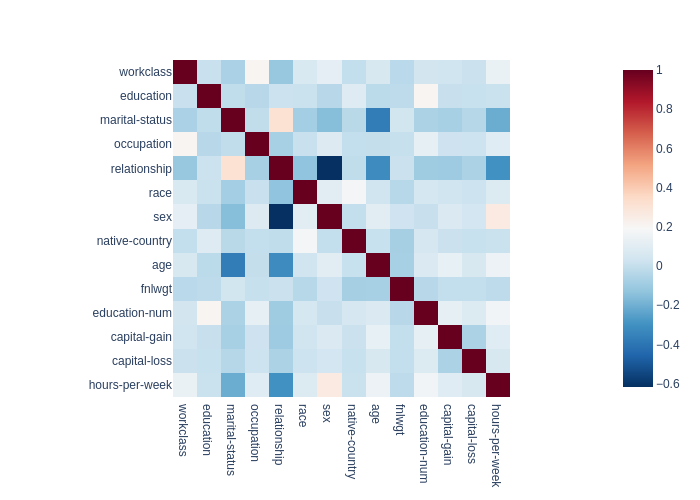

Imbalance#0: features Sex


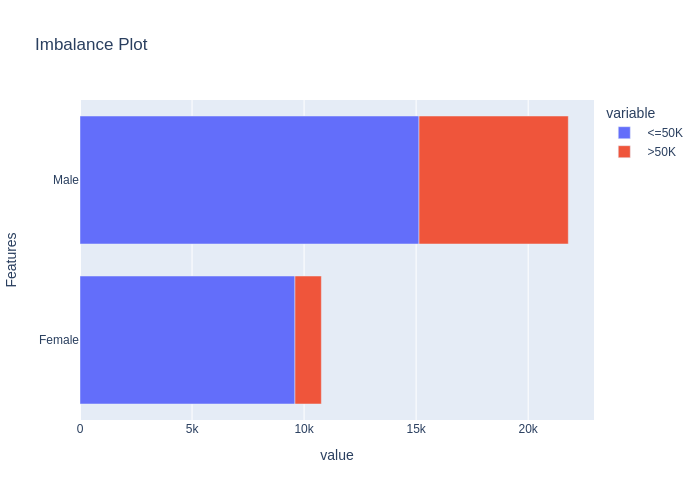

Imbalance#1: features Race


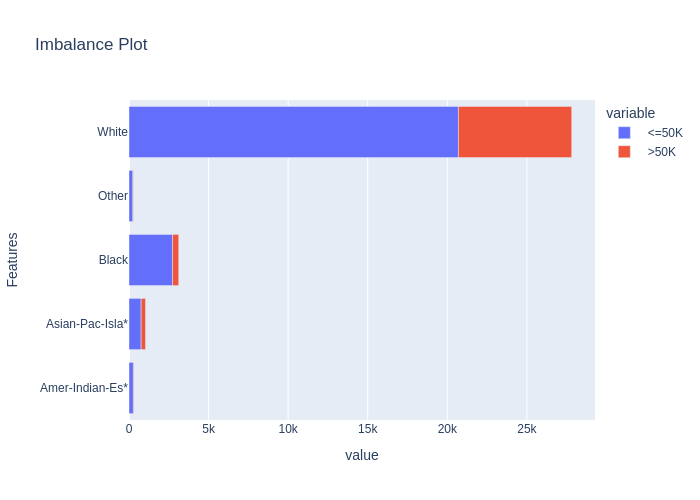

Imbalance#2: features Sex, Race


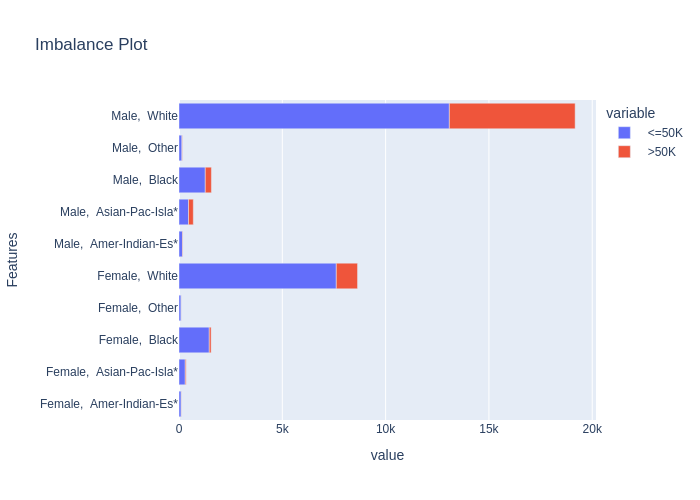

In [31]:
from omnixai.data.tabular import Tabular
from omnixai.explainers.data import DataAnalyzer

tabular_data = Tabular(
    df,
    categorical_columns=['workclass', 'education', 'marital-status',
                         'occupation', 'relationship', 'race', 'sex', 'native-country'],
    target_column='income'
)

# Initialize a `DataAnalyzer` explainer.
# We can choose multiple explainers/analyzers by specifying analyzer names.
# In this example, the first explainer is for feature correlation analysis and
# the others are for feature imbalance analysis (the same explainer with different parameters).
explainer = DataAnalyzer(
    explainers=["correlation", "imbalance#0", "imbalance#1", "imbalance#2"],
    mode="classification",
    data=tabular_data
)
# Generate explanations by calling `explain_global`.
explanations = explainer.explain_global(
    params={"imbalance#0": {"features": ["sex"]},
            "imbalance#1": {"features": ["race"]},
            "imbalance#2": {"features": ["sex", "race"]}}
)

print("Correlation:")
explanations["correlation"].ipython_plot()
print("Imbalance#0: features Sex")
explanations["imbalance#0"].ipython_plot()
print("Imbalance#1: features Race")
explanations["imbalance#1"].ipython_plot()
print("Imbalance#2: features Sex, Race")
explanations["imbalance#2"].ipython_plot()

From the correlation plot we can observe that "Relationship" has strong correlations with "Matrital Status" and "Sex", so we may remove this feature. From the data imbalance plots we can see that the class labels are highly imbalanced among different "Sex" and "Race". Therefore, we will consider ignoring these features when building a machine learning model to avoid sociological bias.

In [32]:
df = df.drop(columns=["sex", "race", "relationship"])
print(df)

       age          workclass  fnlwgt    education  education-num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

            marital-status          occupation  capital-gain  capital-loss  \
0            Never-married        Adm-clerical          2174             0   
1       Married

In the next step, we do a rough feature selection by analyzing the information gain and chi-squared stats between features and targets.
<ul><b>Interpretation:</b>
<li>Mutual Information tells you how much knowing a feature reduces uncertainty about the target.
<li>Chi-Square tells you whether there is a statistically significant relationship between a categorical feature and the target.
</ul>
<ul><b>Practical Explanation Using Your Code</b>
<li>
If "Mutual Information" for Occupation is high, it means Occupation helps predict label well.
<li>If "Chi-Square" for Occupation is significant, it means Occupation and label are not independent, but it doesn’t tell us how much it improves prediction. Chi-Square goes from 0 to infinity - the larger the value the more the dependence between the features.
</ul>
<p>
Mutual information is better for feature selection in machine learning, while chi-square is useful for statistical hypothesis testing.</p>
<p><b>Example:</b> Let's say we're analyzing Education Level vs. Income Group:
<br>
Chi-Square might only tell us if there's a relationship.<br>
Mutual Information tells us how much knowing Education Level helps predict Income Group.<br></p>

<p><b>Feature Importance for model can be explained globally or locally:</b><br>

<b>Global Feature Importance: </b> How important each feature is for the entire dataset.<br>
<b>Local Feature Importance: </b>How important each feature is for a single prediction.<br>
</p>

Mutual information:


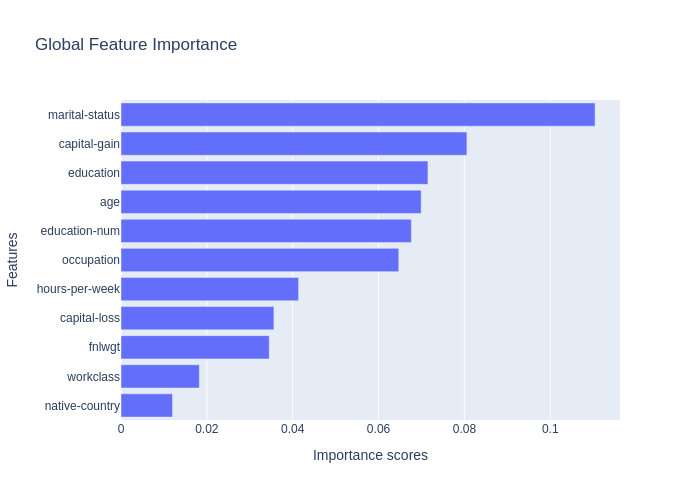

Chi square:


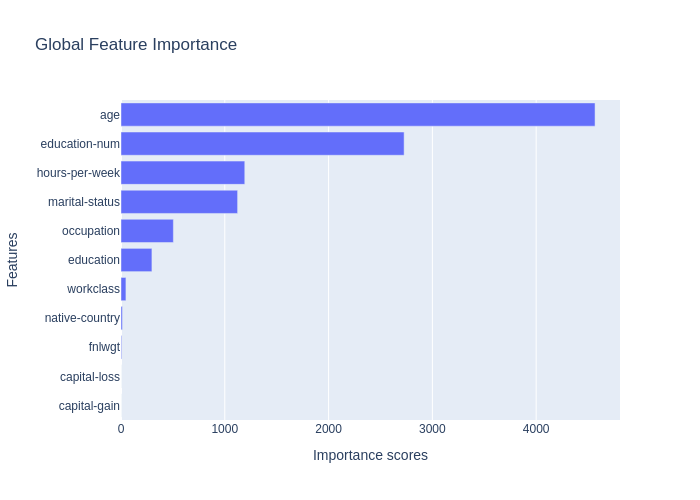

In [33]:
tabular_data = Tabular(
    df,
    categorical_columns=['workclass', 'education', 'marital-status', 'occupation', 'native-country'],
    target_column='income'
)
explainer = DataAnalyzer(
    explainers=["mutual", "chi2"],
    mode="classification",
    data=tabular_data
)
data_explanations = explainer.explain_global()

print("Mutual information:")
data_explanations["mutual"].ipython_plot()
print("Chi square:")
data_explanations["chi2"].ipython_plot()

The most important features showed above are "Age", "Marital Status", "Eduction-Num", "Hours per week", "Occupation" and "Education". "Capital Gain" is not consistent among these two methods, while "Workclass", "Capital Loss", "fnlwgt", and "Native Country" are the least important features, so we may consider to remove them or do further analysis.

In [34]:
# We drop these three features because they have relatively low importance scores.
tabular_data = Tabular(
    df.drop(columns=["capital-loss", "fnlwgt", "native-country"]),
    categorical_columns=['workclass', 'education', 'marital-status', 'occupation'],
    target_column='income'
)
print(tabular_data)

       age          workclass    education  education-num  \
0       39          State-gov    Bachelors             13   
1       50   Self-emp-not-inc    Bachelors             13   
2       38            Private      HS-grad              9   
3       53            Private         11th              7   
4       28            Private    Bachelors             13   
...    ...                ...          ...            ...   
32556   27            Private   Assoc-acdm             12   
32557   40            Private      HS-grad              9   
32558   58            Private      HS-grad              9   
32559   22            Private      HS-grad              9   
32560   52       Self-emp-inc      HS-grad              9   

            marital-status          occupation  capital-gain  hours-per-week  \
0            Never-married        Adm-clerical          2174              40   
1       Married-civ-spouse     Exec-managerial             0              13   
2                 Divorced 

<p>Train two models:<br>
1. XGBoost classifier<br>
2. Random Forest Classifier</p>

In [35]:
import sklearn
import xgboost
from omnixai.preprocessing.tabular import TabularTransform

np.random.seed(12345)
# Train an XGBoost model
transformer = TabularTransform().fit(tabular_data)
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.85)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

class_names = transformer.class_names
gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, train_labels)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, gbtree.predict(test))))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (27676, 51)
Test data shape:     (4885, 51)
Test accuracy: 0.8579324462640737


In [36]:
np.random.seed(12345)
# Train an Random Forest model
transformer = TabularTransform().fit(tabular_data)
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

class_names = transformer.class_names
# Train Random Forest on your training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# The line below has been modified to use the transformed data 'train' instead of 'train_data'
rf_model.fit(train, train_labels)  # Use the transformed data for training
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, rf_model.predict(test))))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (26048, 51)
Test data shape:     (6513, 51)
Test accuracy: 0.8317211730385383


We then create an `TabularExplainer` explainer to generate local and global explanations.

In [37]:
from omnixai.explainers.tabular import TabularExplainer

# Initialize a TabularExplainer
explainers = TabularExplainer(
    explainers=["lime", "shap", "mace", "pdp", "ale"],
    mode="classification",
    data=train_data,
    model=rf_model,
    preprocess=lambda z: transformer.transform(z),
    params={
        "lime": {"kernel_width": 3},
        "shap": {"nsamples": 100},
        "mace": {"ignored_features": ["Marital Status"]}
    }
)

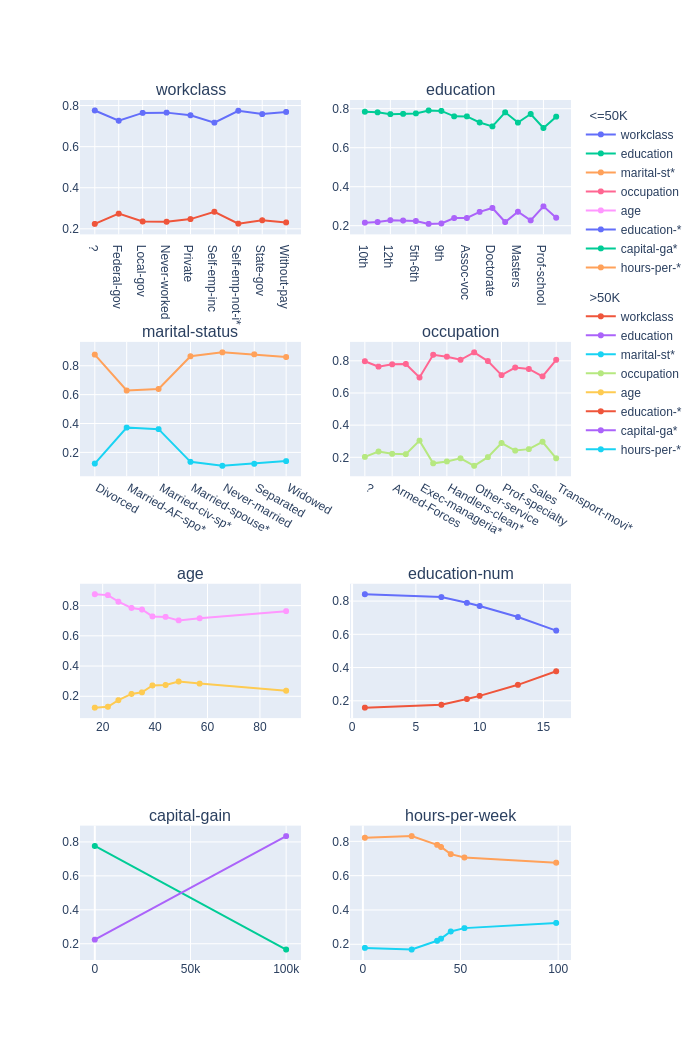

In [42]:
# Generate global explanations
global_explanations = explainers.explain_global()
global_explanations["pdp"].ipython_plot(class_names=class_names)
#The separation between the two lines shows that the model sees a clear difference
#between income groups based on marital status.

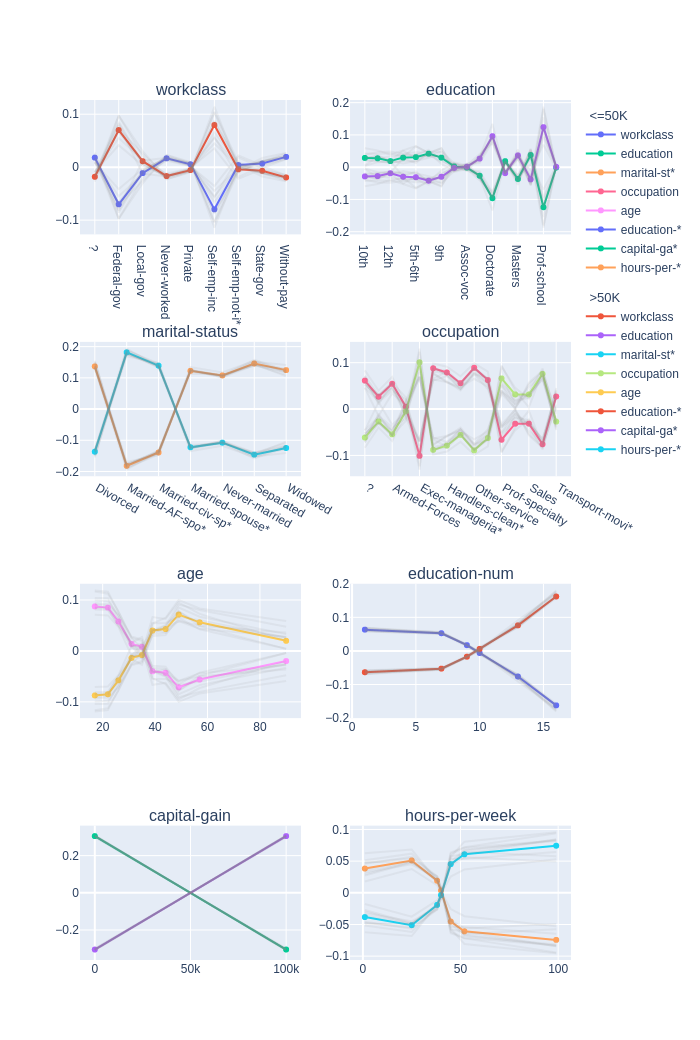

In [48]:
global_explanations["ale"].ipython_plot(class_names=class_names)

The global explanations generated by PDP describe the general behavior of this classifier. For example, the income increases when "Age" increases from 20 to 50 and then decreases a bit after 50. A large number of educations or a longer working time implies a higher income for the model prediction. But note that these results only show how a model makes predictions but don't show causal relationships between each feature and the income, e.g., whether a longer working time is the cause of a higher income or a higher income is the cause of more working hours is unclear.

For some specific test instances, we can generate local explanations to analyze the predictions.

  0%|          | 0/5 [00:00<?, ?it/s]

LIME results:


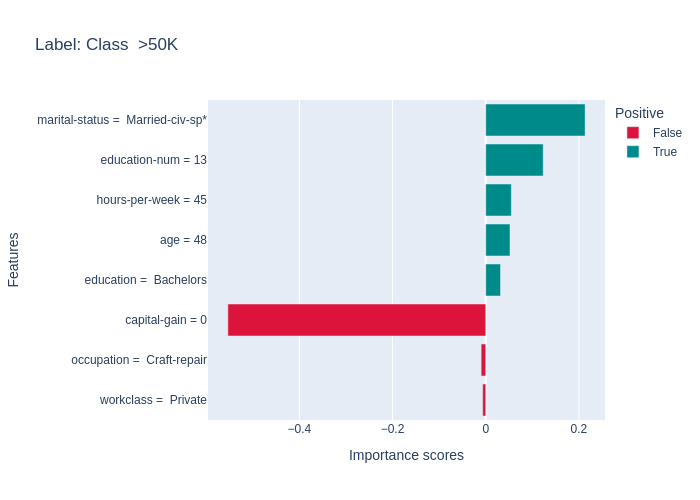

SHAP results:


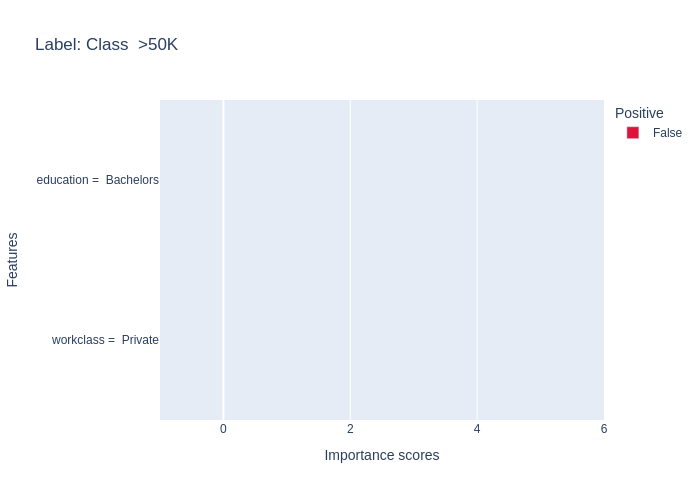

MACE results:


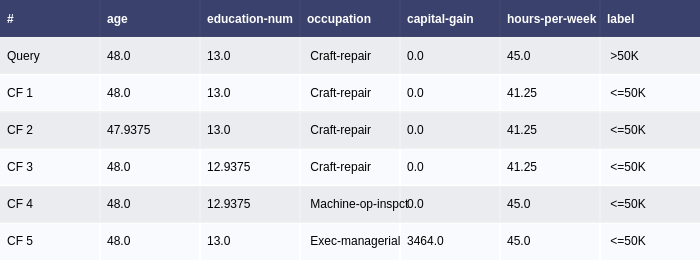

In [43]:
# Generate local explanations
test_instances = test_data[1653:1658]
local_explanations = explainers.explain(X=test_instances)

index = 0
print("LIME results:")
local_explanations["lime"].ipython_plot(index, class_names=class_names)
print("SHAP results:")
local_explanations["shap"].ipython_plot(index, class_names=class_names)
print("MACE results:")
local_explanations["mace"].ipython_plot(index, class_names=class_names)

The results of LIME and SHAP show the feature importance scores for this prediction (the predicted label is > 50k), e.g., the positive features (features making income > 50k) are "Marital Status", "Education-Num", "Age" and "Hours per week", the negative features are "Capital Gain" and "Ocupation". MACE generates several counterfactual examples, e.g., if "Education-Num" is 12 instead of 13 ("Education-Num" decreases) or "Hours per week" decreases to 40, the predicted label will become ">= 50k".

We we create a `PredictionAnalyzer` for computing performance metrics for this task:

In [44]:
# Compute metrics
from omnixai.explainers.prediction import PredictionAnalyzer

analyzer = PredictionAnalyzer(
    mode="classification",
    test_data=test_data,
    test_targets=test_labels,
    model=gbtree,
    preprocess=lambda z: transformer.transform(z)
)
prediction_explanations = analyzer.explain()

metric:


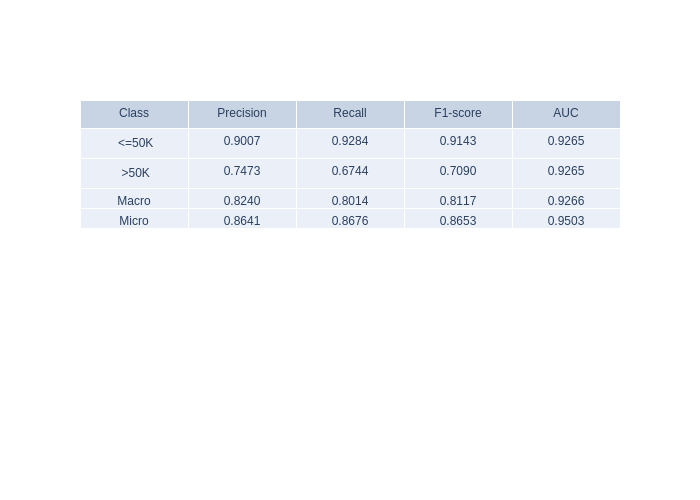

confusion_matrix:


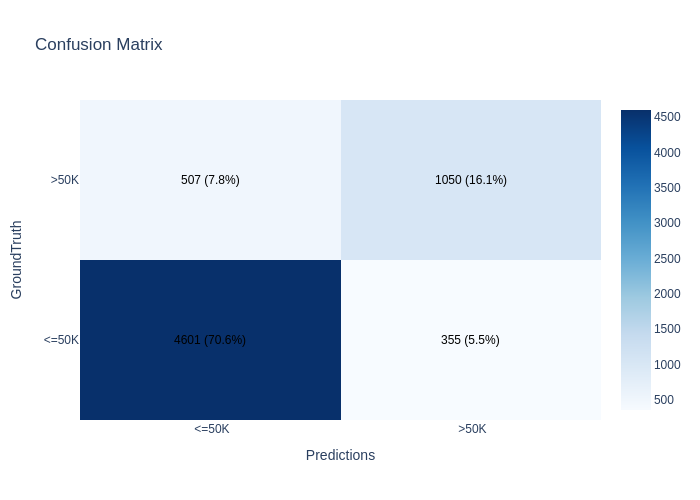

roc:


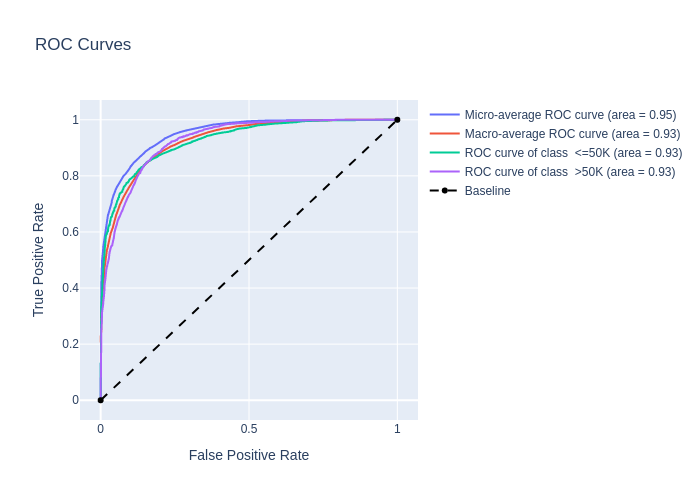

precision_recall:


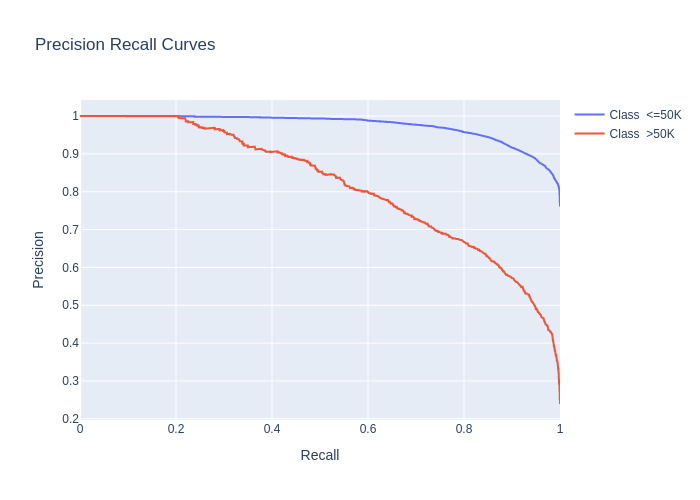

cumulative_gain:


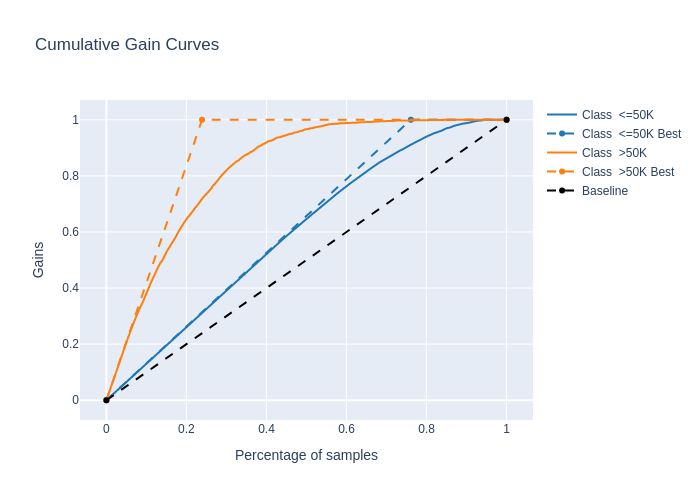

lift_curve:


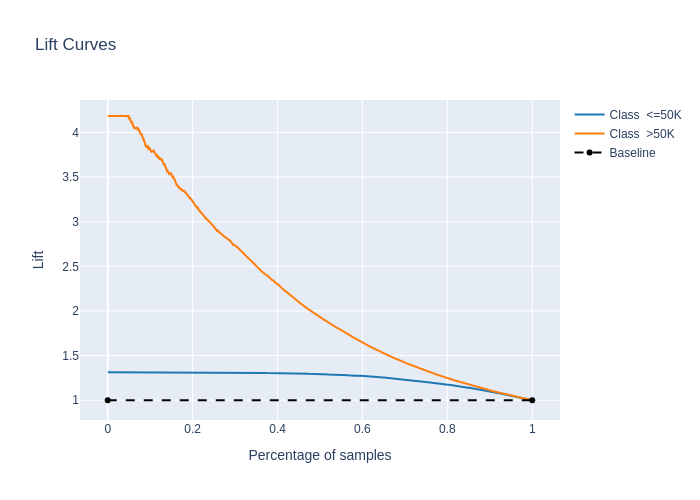

In [45]:
for name, metrics in prediction_explanations.items():
    print(f"{name}:")
    metrics.ipython_plot(class_names=class_names)

We can launch a dashboard to examine all the explanations:

In [46]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [47]:
!pip install jupyter-dash

In [49]:
!pip install dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 6.1 MB/s eta 0:00:00


In [50]:
from omnixai.visualization.dashboard import Dashboard

# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=test_instances,
    data_explanations=data_explanations,
    local_explanations=local_explanations,
    global_explanations=global_explanations,
    prediction_explanations=prediction_explanations,
    class_names=class_names
)
dashboard.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p>License & Citation<br>
OmniXAI is released under the Apache 2.0 License, allowing free use for research and presentations.<br>

Reference:<br>
"Explanations generated using OmniXAI (Salesforce Research, Apache 2.0 License)."<br>
GitHub Repository: https://github.com/salesforce/OmniXAI<br></p>